# Differential expression analysis between samples with high and low tumour cellularity

Script related to figure 3e

### Aim:
- Compare gene expression profiles between high and low tumour cellularity samples with and without patient dependecy

In [1]:
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS High Sierra 10.13.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] compiler_3.5.0  IRdisplay_0.6.1 pbdZMQ_0.3-3    tools_3.5.0    
 [5] htmltools_0.3.6 base64enc_0.1-3 crayon_1.3.4    Rcpp_1.0.1     
 [9] uuid_0.1-2      IRkernel_0.8.14 jsonlite_1.6    digest_0.6.18  
[13] repr_0.17       evaluate_0.13  

## Install packages

In [ ]:
#install.packages('DataCombine')

## Load packages

In [1]:
library(limma)
library(ggplot2)
library(ggrepel)
library(Biobase)
library(statmod)
library(DataCombine)

Warning message:
“package ‘limma’ was built under R version 3.5.1”Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”Warning message:
“package ‘Biobase’ was built under R version 3.5.1”Loading required package: BiocGenerics
Warning message:
“package ‘BiocGenerics’ was built under R version 3.5.1”Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, eval

In [2]:
setwd("~/git_repos/HGSOC_TME_Heterogeneity/Scripts/3/")

## Load gene expression data

In [ ]:
mix <- "../../Data/1/TreatmentNaive_log2exp_loess_norm.txt"

In [3]:
data <- read.csv(mix,
                 sep='\t',
                 header=T,
                 row.names='Hugo_Symbol')

In [4]:
head(data)

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,⋯,C06,C07,C08,C09,C10,C11,C12,D01,D02,D03
A1BG,4.124711,3.880633,4.864973,4.167882,4.317845,3.679057,4.092837,4.370571,4.252637,4.174694,⋯,3.804537,4.416981,4.169014,4.503313,4.146333,4.078398,4.011369,3.845128,3.600927,4.521857
A2BP1,3.960924,4.033715,3.721251,3.916073,4.338194,3.357396,3.872447,3.803388,3.484735,4.427405,⋯,4.991068,3.799913,4.117883,4.122134,4.221760,3.648326,3.675317,3.546925,3.788279,4.920841
A2M,12.603155,10.859838,12.612923,9.176999,10.548790,11.840776,7.200547,11.835658,11.535547,7.080118,⋯,9.061598,9.189459,8.844728,7.464440,6.726233,9.265911,10.740486,9.735582,10.781599,8.734304
A2ML1,3.945877,4.000621,3.767932,3.789729,3.543204,3.805520,4.336280,4.031757,4.166018,3.673146,⋯,4.231174,3.871651,3.287232,3.721093,3.723801,3.884499,3.694111,3.937682,3.600471,3.402861
A4GALT,3.597277,3.863757,4.051844,4.113169,3.975144,3.991293,5.439960,4.696177,4.171788,4.041633,⋯,4.183089,4.699729,4.019537,3.739865,4.591953,4.997860,4.099630,5.001239,4.714710,4.145119
A4GNT,3.714481,3.593169,3.241352,3.515850,3.364447,3.767865,3.768695,3.163977,3.423377,3.205154,⋯,3.896812,3.915653,3.351422,3.719759,3.641028,3.114521,3.560199,3.539738,3.760903,3.479266


In [5]:
length(data)

[1] 38

### Remove samples B12 and C08 since they do not have matching WES data

In [6]:
data <- subset(data,
               select=-c(B12,C08))

In [7]:
length(data)

[1] 36

### Convert dataframe to limma object

In [6]:
eset <- new("ExpressionSet",
            exprs=as.matrix(data))

### Check densities

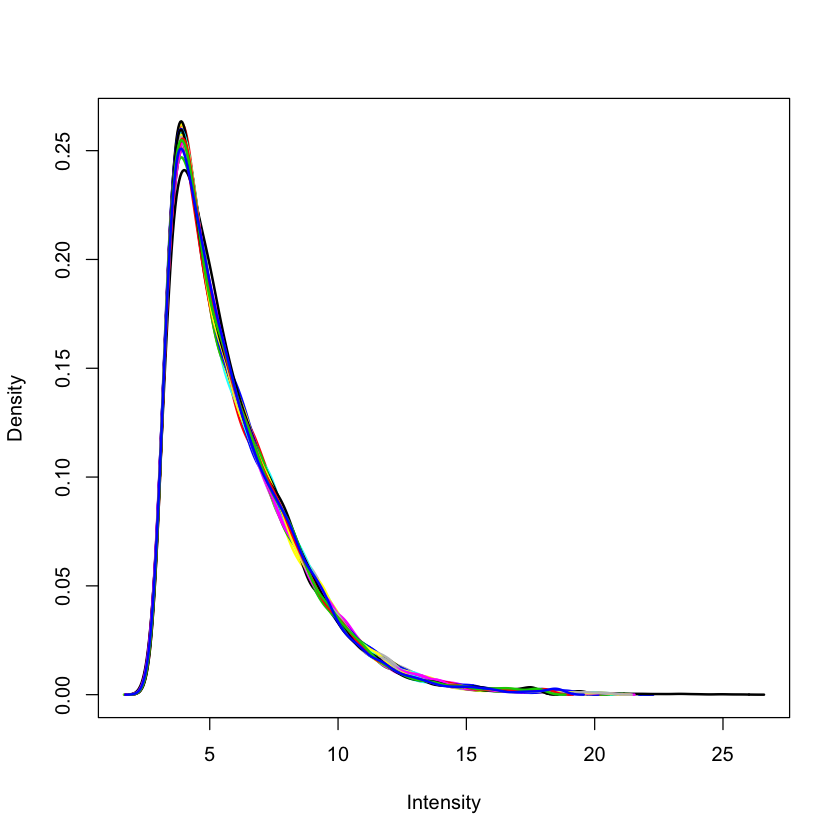

In [7]:
plotDensities(eset,legend=F)

## Get samples labels data

In [8]:
file_keys = home + 'Data/1/TreatmentNaive_SampleLabels_WESTumourCellularity.txt'

sample_labels <- read.csv(file_keys,
                          sep='\t',
                          header=T,
                          row.names='Well')

In [9]:
head(sample_labels)

,Label,Key,Case_mRNA,Site,Habitat,Case_WES,Tumour_WES,Colour,Site_marker,TumourCellularity_WES
A01,A01_3640_5_Omentum,case10_omentum_green,10,omentum,green,10,5,#ff7f00,^,0.5973
A02,A02_3640_7_Omentum,case10_omentum_blue,10,omentum,blue,10,7,#ff7f00,^,0.5065
A03,A03_3640_9_Paracolic_Gutter,case10_paracolic_yellow,10,other,yellow,10,8,#ff7f00,s,0.4551
A04,A04_3640_17_R_Adnexa,case10_Radnexa_yellow,10,ovary,yellow,10,17,#ff7f00,o,0.6496
A05,A05_3640_18_R_Adnexa,case10_Radnexa_blue,10,ovary,blue,10,18,#ff7f00,o,0.6706
A06,A06_3640_19_R_Adnexa,case10_Radnexa_green,10,ovary,green,10,19,#ff7f00,o,0.6695


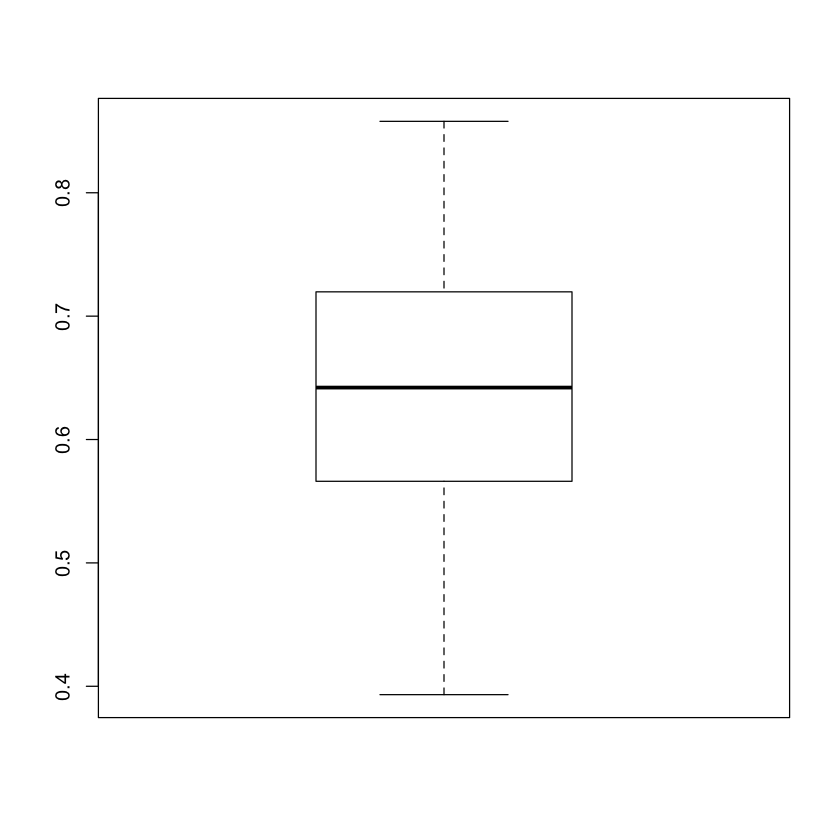

In [10]:
boxplot(sample_labels[,'TumourCellularity_WES'])

### Remove samples B12 and C08 that do not have matching WES mRNA data

In [11]:
sample_labels[,'TumourCellularity_WES']

[1] 0.5973 0.5065 0.4551 0.6496 0.6706 0.6695 0.7275 0.7929 0.7211 0.7920
[11] 0.7017 0.5246 0.8579 0.7423 0.7183 0.7157 0.6561 0.6437 0.6137 0.6085
[21] 0.5533 0.5763     NA 0.6405 0.6084 0.5633 0.5549 0.4650 0.6625 0.6217
[31]     NA 0.7377 0.7359 0.3932 0.4936 0.5690 0.5998 0.8010

In [12]:
sample_labels_woNa <- DropNA(sample_labels)

No Var specified. Dropping all NAs from the data frame.

2 rows dropped from the data frame because of missing values.


In [13]:
sample_labels_woNa[,'TumourCellularity_WES']

[1] 0.5973 0.5065 0.4551 0.6496 0.6706 0.6695 0.7275 0.7929 0.7211 0.7920
[11] 0.7017 0.5246 0.8579 0.7423 0.7183 0.7157 0.6561 0.6437 0.6137 0.6085
[21] 0.5533 0.5763 0.6405 0.6084 0.5633 0.5549 0.4650 0.6625 0.6217 0.7377
[31] 0.7359 0.3932 0.4936 0.5690 0.5998 0.8010

### Define median tumour cellularity

In [14]:
med_tumCell <- median(sample_labels_woNa[,'TumourCellularity_WES'])
med_tumCell

[1] 0.6421

In [15]:
tumcell <- as.data.frame(ifelse(sample_labels_woNa[,'TumourCellularity_WES'] > med_tumCell, 'high','low'))

row.names(tumcell) <- row.names(sample_labels_woNa)

colnames(tumcell)[1] <- 'TumourCellularity_WES_bin'

In [16]:
head(tumcell)

,TumourCellularity_WES_bin
A01,low
A02,low
A03,low
A04,high
A05,high
A06,high


In [17]:
sample_labels_woNa_tumcellbin <- merge(sample_labels_woNa,
                                       tumcell,
                                       by='row.names')

In [18]:
row.names(sample_labels_woNa_tumcellbin) <- row.names(tumcell)
sample_labels_woNa_tumcellbin$Row.names <- NULL

In [19]:
head(sample_labels_woNa_tumcellbin)

,Label,Key,Case_mRNA,Site,Habitat,Case_WES,Tumour_WES,Colour,Site_marker,TumourCellularity_WES,TumourCellularity_WES_bin
A01,A01_3640_5_Omentum,case10_omentum_green,10,omentum,green,10,5,#ff7f00,^,0.5973,low
A02,A02_3640_7_Omentum,case10_omentum_blue,10,omentum,blue,10,7,#ff7f00,^,0.5065,low
A03,A03_3640_9_Paracolic_Gutter,case10_paracolic_yellow,10,other,yellow,10,8,#ff7f00,s,0.4551,low
A04,A04_3640_17_R_Adnexa,case10_Radnexa_yellow,10,ovary,yellow,10,17,#ff7f00,o,0.6496,high
A05,A05_3640_18_R_Adnexa,case10_Radnexa_blue,10,ovary,blue,10,18,#ff7f00,o,0.6706,high
A06,A06_3640_19_R_Adnexa,case10_Radnexa_green,10,ovary,green,10,19,#ff7f00,o,0.6695,high


### Tumour cellularity binary call as factor

In [20]:
tumcellbin <- factor(sample_labels_woNa_tumcellbin$TumourCellularity_WES_bin)

In [21]:
tumcellbin

[1] low  low  low  high high high high high high high high low  high high high
[16] high high high low  low  low  low  low  low  low  low  low  high low  high
[31] high low  low  low  low  high
Levels: high low

### Design matrix

In [22]:
design <- model.matrix(~0+tumcellbin)
colnames(design) <- levels(tumcellbin)

In [23]:
head(design)

,high,low
1,0,1
2,0,1
3,0,1
4,1,0
5,1,0
6,1,0


## Estimate correlation between measurements on same subjects

### Consider repeated measurements in the individuals

In [24]:
corfit <- duplicateCorrelation(eset,
                               design,
                               block=sample_labels_woNa_tumcellbin$Case_mRNA)

corfit$consensus

[1] 0.1763727

### Inter-subject correlation is input into the linear model fit

In [25]:
fit <- lmFit(eset,
             design,
             block=sample_labels_woNa_tumcellbin$Case_mRNA,
             correlation=corfit$consensus)

In [26]:
cm <- makeContrasts(
      High_vs_Low = high-low,
      levels=design)

cm

,High_vs_Low
high,1
low,-1


In [27]:
fit2 <- contrasts.fit(fit, cm)
fit2 <- eBayes(fit2)

In [28]:
topTable(fit2,
         coef="High_vs_Low",
         adjust='fdr')

,logFC,AveExpr,t,P.Value,adj.P.Val,B
CYBB,-1.870505,7.517236,-7.383829,9.506638e-09,0.0001394434,9.284987
VAMP5,-1.638811,7.159211,-5.762822,1.374465e-06,0.0100803241,5.020438
APOC1,-2.131354,12.821060,-5.479986,3.302432e-06,0.0105828459,4.257513
IL7R,-3.111353,10.072070,-5.426074,3.902423e-06,0.0105828459,4.111945
NKG7,-1.178869,6.407097,-5.360814,4.775790e-06,0.0105828459,3.935731
CD53,-1.710032,9.386776,-5.338679,5.114235e-06,0.0105828459,3.875965
PTPRC,-2.794075,10.750614,-5.322007,5.384832e-06,0.0105828459,3.830953
BAIAP2L1,1.462222,7.874020,5.290740,5.931338e-06,0.0105828459,3.746542
LST1,-1.030270,6.549354,-5.261441,6.493429e-06,0.0105828459,3.667457
RARRES3,-1.987022,8.487008,-5.205277,7.723262e-06,0.0113284801,3.515899


In [29]:
?decideTests

In [ ]:
results <- decideTests(fit2,
                       adjust.method='fdr')

In [ ]:
head(results)

In [ ]:
results[results[,'High_vs_Low'] == 1,]

In [ ]:
length(results[results[,'High_vs_Low'] == -1,])

In [ ]:
number_of_DE_genes <- length(results[results[,'High_vs_Low'] != 0,])

In [ ]:
vennDiagram(results)

## Volcanoplot

<p> Ref1: https://support.bioconductor.org/p/98442/ </p>
<p> Ref2: https://support.bioconductor.org/p/62384/ </p>
<p> Ref3: https://support.bioconductor.org/p/6124/ </p>

### Plot limma's default volcano plot

In [ ]:

volcanoplot(fit2,
            style='p-value',
            highlight=number_of_DE_genes,
            names=row.names(results),
            hl.col='blue',
            cex=0.3)

lp <- -log10(fit2$p.value[,"High_vs_Low"])
ord <- order(lp, decreasing = TRUE)[1:32]
points(fit2$coef[ord,"High_vs_Low"], lp[ord], pch = 16, cex = 0.3, col = 2)


### Save beautified volcano plot

In [ ]:
pure_de <- topTable(fit2, coef = 'High_vs_Low', number = Inf)

purity.plot <- c()
genes <- pure_de
genes$Significant <- ifelse(genes$adj.P.Val < 0.05,
                            ifelse(genes$logFC > 0,
                                   'Up',
                                   ifelse(genes$logFC < 0,'Down',
                                          'Not_Sig')),
                            'Not_Sig')

In [ ]:
pdf('../../Figures/main/3/panels/3e_differential_expression_highlow_tumour_cellularity_patientdependent.pdf')

pure.plot <- ggplot(genes, aes(x = logFC, y = -log10(P.Value))) +
    geom_point(aes(size = Significant,
               alpha = Significant,
               colour = Significant,
               shape = Significant,
               stroke = 0
             )) +
    scale_color_manual(values = c('darkred','grey15','forestgreen'),guide = FALSE) +
    scale_shape_manual(values = c(16,16,16),guide = FALSE) +
    scale_size_manual(values = c(1,1,1),guide = FALSE) +
    scale_alpha_manual(values = c(1,1,1),guide = FALSE) +
    theme_classic() +
    geom_text_repel(
        data = subset(genes, Significant %in% c('Up', 'Down')),
        aes(label = row.names(subset(genes, Significant %in% c('Up', 'Down')))),
        size = 2.5,
        box.padding = unit(0.15, "lines"),
        point.padding = unit(0.1, "lines")
      ) +
     scale_x_continuous(limits = c(-4, 4), breaks = c(-3,-2,-1,0,1,2,3))
pure.plot

dev.off()

### Sort genes by moderated t-statistic

#### Number of genes (features)

In [ ]:
dim(eset)

In [ ]:
topTable(fit2,
         coef="High_vs_Low",
         adjust='BH',
         sort.by='t',
         number=32)

In [ ]:
de_statistics <- topTable(fit2,
                          coef="High_vs_Low",
                          adjust='BH',
                          sort.by='t',
                          number=14668)

### Save differential expression results

In [ ]:
de_statistics <- data.frame("Hugo_symbol"=rownames(de_statistics),
                            de_statistics)

rownames(de_statistics) <- NULL

In [ ]:
write.table(de_statistics,
            file='../../Data/3/Diff_exp_highlow_tum_cell_patientdependent.txt',
            sep='\t',
            row.names=F,
            col.names=T)

### Save differentially expressed genes in high tumour cellularity tumours

In [ ]:
hgenes <- row.names(as.data.frame(results[results[,'High_vs_Low'] == 1,]))

In [ ]:
subset(de_statistics, de_statistics$Hugo_symbol %in% hgenes)

In [ ]:
high_genes <- subset(de_statistics, de_statistics$Hugo_symbol %in% hgenes)

In [ ]:
rownames(high_genes) <- NULL
high_genes

In [ ]:
write.table(high_genes,
            file='../../Data/3/Diff_exp_high_tum_cell_patientdependent.txt',
            sep='\t',
            row.names=F,
            col.names=T)

### Save differentially expressed genes in low tumour cellularity tumours

In [ ]:
lgenes <- row.names(as.data.frame(results[results[,'High_vs_Low'] == -1,]))

In [ ]:
head(subset(de_statistics, de_statistics$Hugo_symbol %in% lgenes))

In [ ]:
low_genes <- subset(de_statistics, de_statistics$Hugo_symbol %in% lgenes)

In [ ]:
rownames(low_genes) <- NULL
head(low_genes)

In [ ]:
write.table(low_genes,
            file='../../Data/3/Diff_exp_low_tum_cell_patientdependent.txt',
            sep='\t',
            row.names=F,
            col.names=T)

In [ ]:
low_genes$Hugo_symbol

# End script